In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import csv

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('CUDA:', torch.cuda.is_available(), ' Use << {} >>'.format(device.upper()))
print('PyTorch Version:', torch.__version__)

CUDA: True  Use << CUDA >>
PyTorch Version: 1.7.1+cu110


In [3]:
class CSVDataset(Dataset):
    def __init__(self, file_name):

        dataframe = pd.read_csv(file_name)
        
        x = dataframe.iloc[:,0:45].values # inputs
        y = dataframe.iloc[:, 45].values # labels
        y = (y-100)/100 # labels must start at 0 so adjust this to your data
        
        #converting to torch tensors
        self.x = torch.tensor(x, dtype=torch.float32) 
        self.y = torch.tensor(y, dtype=torch.int64)
        
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx): 
        return self.x[idx], self.y[idx]

In [4]:
class TrainSet(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [5]:
input_data = CSVDataset('.csv') # adjust this to your file name

X_train, X_test, y_train, y_test = train_test_split(input_data.x, input_data.y, test_size=0.2, shuffle = True)

# Save train data set
f = open('.csv','w', newline='')
wr = csv.writer(f)

for i in range(len(y_train)):
    wr.writerow([X_train[i][0:45], y_train[i]])
    
f.close()

# Save test data set
f = open('.csv','w', newline='')
wr = csv.writer(f)

for i in range(len(y_test)):
    wr.writerow([X_test[i][0:45], y_test[i]])
    
f.close()

In [6]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape torch.Size([4325, 45]) torch.Size([4325])
Testing Shape torch.Size([1082, 45]) torch.Size([1082])


In [7]:
X_train_final = torch.reshape(X_train, (X_train.shape[0], 5, int(X_train.shape[1]/5)))
X_test_final = torch.reshape(X_test, (X_test.shape[0], 5, int(X_test.shape[1]/5)))

print(X_train_final.shape)
print(X_test_final.shape)

torch.Size([4325, 5, 9])
torch.Size([1082, 5, 9])


In [8]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes # number of classes
        self.num_layers = num_layers # number of layers
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # hidden state
        self.seq_length = seq_length # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) # lstm module
        self.fc =  nn.Linear(hidden_size, num_classes)


        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device) # hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device) # internal state
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm with input, hidden, and internal state
        hn = hn[num_layers-1] # reshaping the data for Dense layer next
        
        out = self.fc(hn)
        
        return out

In [9]:
epoches = 200
batch_size = 20
learning_rate = 0.0001

input_size = 9
hidden_size = 300
num_layers = 2
seq_length = 5

num_classes = 10

In [10]:
trainset = TrainSet(X_train_final, y_train)
testset = TrainSet(X_test_final, y_test)

trainLoader = torch.utils.data.DataLoader(trainset, batch_size, shuffle = True)
testLoader = torch.utils.data.DataLoader(testset, batch_size, shuffle = True)

model = LSTM1(num_classes, input_size, hidden_size, num_layers, seq_length)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

print(model)

LSTM1(
  (lstm): LSTM(9, 300, num_layers=2, batch_first=True)
  (fc): Linear(in_features=300, out_features=10, bias=True)
  (relu): ReLU()
)


In [11]:
def accuracy_check_for_batch(labels, preds, batch_size):
    total_acc = 0
    for i in range(batch_size):        
        total_acc += accuracy_check(labels[i], preds[i])
    return total_acc/batch_size

In [12]:
def get_loss_train(model, trainloader, criterion, device):
    model.eval()
    total_acc = 0
    total_loss = 0
    
    for batch, (inputs, labels) in enumerate(trainLoader):
        with torch.no_grad():
            inputs = inputs.to(device)   
            labels = labels.to(device = device, dtype = torch.int64)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            preds = torch.argmax(outputs, dim=1)
            acc = accuracy_check_for_batch(labels, preds, inputs.size()[0])
            total_acc += acc
            total_loss += loss.cpu().item()
        
    return total_acc/(batch+1), total_loss/(batch+1)

In [13]:
def accuracy_check(label, pred):
    ims = [label, pred]
    np_ims = []
    for item in ims:
        item = item.cpu().numpy()
        np_ims.append(item)
    compare = np.equal(np_ims[0], np_ims[1])
    accuracy = np.sum(compare)
    return accuracy / len(np_ims[0].flatten())

In [14]:
def train_model(model, trainLoader, criterion, optimizer, scheduler, device):
    model.train()
    
    for i, (inputs, labels) in enumerate(trainLoader): # for one batch
        current_loss = 0.0
        
        inputs = inputs.to(device)
        labels = labels.to(device=device, dtype=torch.int64)
        
        
        criterion = criterion
        outputs = model(inputs)
        
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()

In [15]:
def val_model(model, valLoader, criterion, device):
    total_val_loss=0
    total_val_acc=0
    for batch, (inputs, labels) in enumerate(valLoader): # for one batch
            with torch.no_grad():
                inputs = inputs.to(device)
                labels = labels.to(device=device, dtype=torch.int64)
        
                outputs = model(inputs)
                loss = criterion(outputs, labels)
        
                preds = torch.argmax(outputs, dim=1)
                
                acc = accuracy_check_for_batch(labels, preds, inputs.size()[0])
                total_val_acc += acc
                total_val_loss += loss.cpu().item()
                
                
    return total_val_acc/(batch+1), total_val_loss/(batch+1)

In [16]:
def print_pred(model, finalLoader, device):
    f = open('.csv','w', newline='')
    for i, (inputs, labels) in enumerate(finalLoader):
        with torch.no_grad():
                inputs = inputs.to(device)
                labels = labels.to(device=device, dtype=torch.int64)
                
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                
                wr = csv.writer(f)
                wr.writerow([inputs[0][0][0], inputs[0][0][1], inputs[0][0][2], inputs[0][0][3], inputs[0][0][4], inputs[0][0][5], inputs[0][0][6], inputs[0][0][7], inputs[0][0][8], inputs[0][1][0], inputs[0][1][1], inputs[0][1][2], inputs[0][1][3], inputs[0][1][4], inputs[0][1][5], inputs[0][1][6], inputs[0][1][7], inputs[0][1][8], inputs[0][2][0], inputs[0][2][1], inputs[0][2][2], inputs[0][2][3], inputs[0][2][4], inputs[0][2][5], inputs[0][2][6], inputs[0][2][7], inputs[0][2][8], inputs[0][3][0], inputs[0][3][1], inputs[0][3][2], inputs[0][3][3], inputs[0][3][4], inputs[0][3][5], inputs[0][3][6], inputs[0][3][7], inputs[0][3][8], int(inputs[0][4][0]), float(inputs[0][4][1]), float(inputs[0][4][2]), float(inputs[0][4][3]), int(inputs[0][4][4]), int(inputs[0][4][5]), int(inputs[0][4][6]), int(inputs[0][4][7]), int(inputs[0][4][8]), int(labels[0]), int(preds[0])])
                
    f.close()

In [17]:
print("Training\n")
for epoch in range(epoches):
    
    train_model(model, trainLoader, criterion, optimizer, scheduler, device)
    train_acc, train_loss = get_loss_train(model, trainLoader, criterion, device)
    print("epoch : {:<5} train loss : {:<15.5f} train acc : {:<10.5f}".format(epoch+1, train_loss, train_acc))
    
    val_acc, val_loss = val_model(model, testLoader, criterion, device)
    print("epoch : {:<5} val loss : {:<17.5f} val acc : {:<10.5f}\n".format(epoch+1, val_loss, val_acc))
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    
print("\nTraining Finished")

Training

epoch : 1     train loss : 1.15838         train acc : 0.65991   
epoch : 1     val loss : 1.16269           val acc : 0.65364   

epoch : 2     train loss : 0.92554         train acc : 0.68111   
epoch : 2     val loss : 0.91237           val acc : 0.67273   

epoch : 3     train loss : 0.79592         train acc : 0.71889   
epoch : 3     val loss : 0.79572           val acc : 0.69909   

epoch : 4     train loss : 0.74214         train acc : 0.76060   
epoch : 4     val loss : 0.72764           val acc : 0.76545   

epoch : 5     train loss : 0.69583         train acc : 0.76636   
epoch : 5     val loss : 0.69004           val acc : 0.76000   

epoch : 6     train loss : 0.67673         train acc : 0.78041   
epoch : 6     val loss : 0.67078           val acc : 0.76727   

epoch : 7     train loss : 0.65172         train acc : 0.79171   
epoch : 7     val loss : 0.65484           val acc : 0.78545   

epoch : 8     train loss : 0.65406         train acc : 0.76682   
epoch :

epoch : 63    val loss : 0.57660           val acc : 0.79909   

epoch : 64    train loss : 0.47051         train acc : 0.83664   
epoch : 64    val loss : 0.57679           val acc : 0.80000   

epoch : 65    train loss : 0.47967         train acc : 0.83525   
epoch : 65    val loss : 0.56701           val acc : 0.80545   

epoch : 66    train loss : 0.47272         train acc : 0.83664   
epoch : 66    val loss : 0.56175           val acc : 0.80545   

epoch : 67    train loss : 0.48356         train acc : 0.83180   
epoch : 67    val loss : 0.58039           val acc : 0.80818   

epoch : 68    train loss : 0.48141         train acc : 0.83341   
epoch : 68    val loss : 0.58291           val acc : 0.80273   

epoch : 69    train loss : 0.45746         train acc : 0.84032   
epoch : 69    val loss : 0.56084           val acc : 0.79909   

epoch : 70    train loss : 0.49055         train acc : 0.83710   
epoch : 70    val loss : 0.59200           val acc : 0.79455   

epoch : 71    trai

In [18]:
finalLoader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle = False)
print_pred(model, finalLoader, device)

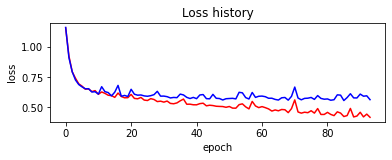

Text(0, 0.5, 'accuracy')

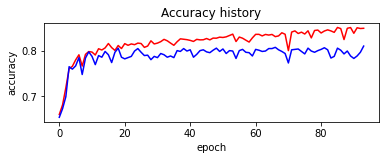

In [19]:
import matplotlib.pyplot as plt

plt.subplot(2,1,1)
plt.plot(range(epoch+1), history['train_loss'], label='Loss', color='red')
plt.plot(range(epoch+1), history['val_loss'], label='Loss', color='blue')

plt.title('Loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.subplot(2,1,2)
plt.plot(range(epoch+1), history['train_acc'], label='Accuracy', color='red')
plt.plot(range(epoch+1), history['val_acc'], label='Accuracy', color='blue')

plt.title('Accuracy history')
plt.xlabel('epoch')
plt.ylabel('accuracy')